<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [2]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [3]:
# Load the data
house = pd.read_csv('./housing.csv')

house.head()



,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
house.isnull().sum().sort_values(ascending=False)
# Drop MiscFeature, Alley, GarageType,GarageCond,GarageYrBlt,GarageFinish,GarageQual,BsmtExposure,BsmtFinType2,
#BsmtFinType1,BsmtCond,BsmtQual,MasVnrArea,MasVnrType,MasVnrType,Electrical

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
LotFrontage       259
GarageCond         81
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageQual         81
BsmtExposure       38
BsmtFinType2       38
BsmtFinType1       37
BsmtCond           37
BsmtQual           37
MasVnrArea          8
MasVnrType          8
Electrical          1
Utilities           0
YearRemodAdd        0
MSSubClass          0
Foundation          0
ExterCond           0
ExterQual           0
Exterior2nd         0
Exterior1st         0
RoofMatl            0
RoofStyle           0
YearBuilt           0
                 ... 
GarageArea          0
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
3SsnPorch           0
BsmtUnfSF           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SaleType            0
Functional          0
TotRmsAbvGrd        0
KitchenQua

In [5]:

house.shape #1460, 81

(1460, 81)

In [6]:
#Remove houses that are not in residential area
hs=house[house['MSZoning']=='FV'] #68 rows
hs2=house[house['MSZoning']=='I']
hs3=house[house['MSZoning']=='A']
hs4=house[house['MSZoning']=='C']

house=house[house.MSZoning!='FV'] 

house=house[house.MSZoning!='C (all)'] # Remove 10 rows
house.shape

(1385, 81)

In [7]:
house['SalePrice'].describe()

count      1385.000000
mean     180136.283032
std       79906.363281
min       37900.000000
25%      129000.000000
50%      160000.000000
75%      212900.000000
max      755000.000000
Name: SalePrice, dtype: float64

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


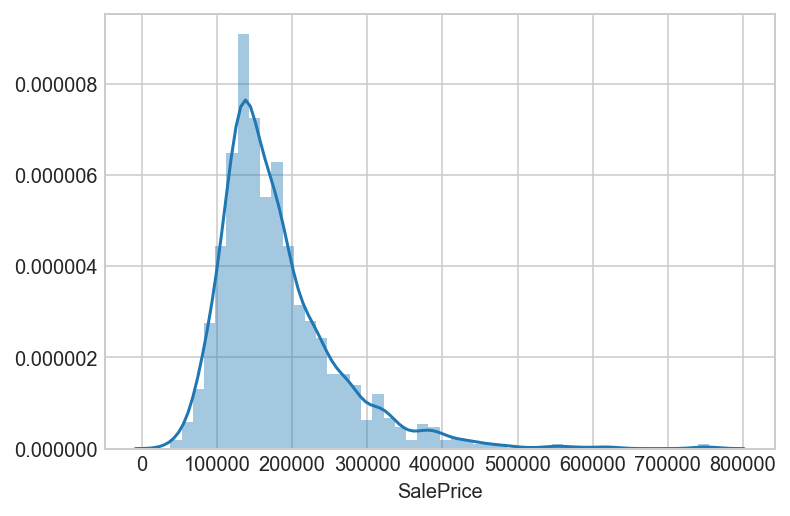

In [8]:
sns.distplot(house['SalePrice'])

In [9]:
sub=house.MSZoning=='C (all)'# 10 rows
house[sub]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [10]:
#check for the unusal characters in nueric columns
n = house.select_dtypes(include='number')
for c in n.columns:
   print(c, ': ', house[c].unique())

Id :  [   1    2    3 ..., 1458 1459 1460]
MSSubClass :  [ 60  20  70  50 190  45  90 120  30  85  80  75 180 160  40]
LotFrontage :  [  65.   80.   68.   60.   84.   85.   75.   nan   51.   50.   70.   91.
   72.   66.  101.   57.   44.  110.   98.   47.  108.  112.   74.  115.
   61.   48.   33.   52.  100.   89.   63.   76.   81.   95.   69.   21.
   32.   78.  121.  122.   73.   77.   64.   94.  105.   90.   55.   88.
   82.   71.   24.  120.  107.   92.  134.   40.   62.   86.  141.   97.
   54.   41.   79.  174.   99.   67.   83.   43.  103.   93.   30.  129.
  140.   34.   37.  118.   87.  116.  150.  111.   49.   96.   59.   36.
   56.   58.   38.  109.  130.   53.  137.   35.   45.  106.  104.   42.
   39.  144.  114.  102.  128.  149.  313.  168.  182.  138.  160.  152.
  124.  153.   46.]
LotArea :  [ 8450  9600 11250 ..., 17217 13175  9717]
OverallQual :  [ 7  6  8  5  9  4 10  3  1  2]
OverallCond :  [5 8 6 7 4 3 9 2 1]
YearBuilt :  [2003 1976 2001 1915 2000 1993 2004 1973

In [11]:
#Check for the unusual characters in object columns
n = house.select_dtypes(include=object)
for c in n.columns:
   print(c, ': ', house[c].unique())

MSZoning :  ['RL' 'RM' 'RH']
Street :  ['Pave' 'Grvl']
Alley :  [nan 'Grvl' 'Pave']
LotShape :  ['Reg' 'IR1' 'IR2' 'IR3']
LandContour :  ['Lvl' 'Bnk' 'Low' 'HLS']
Utilities :  ['AllPub' 'NoSeWa']
LotConfig :  ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
LandSlope :  ['Gtl' 'Mod' 'Sev']
Neighborhood :  ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Condition1 :  ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Condition2 :  ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
BldgType :  ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
HouseStyle :  ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
RoofStyle :  ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
RoofMatl :  ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll' 'ClyTile']
Ext

In [12]:
#house.MasVnrArea

In [13]:
#Mark the house which does not have pool
#house.fillna({'PoolQC':'No Pool'},inplace=True)

In [14]:
# Mark the No Fence House
#house.fillna({'Fence':'No Fence'},inplace=True)

In [15]:
# Mark the No FirePlace houses
#house.fillna({'FireplaceQu':'No FirePlace'},inplace=True)

In [16]:
#Houses which dont have a garage
#house.fillna({'GarageType':'No Garage'},inplace=True)
#subset=house['GarageType']='No FirePlace'

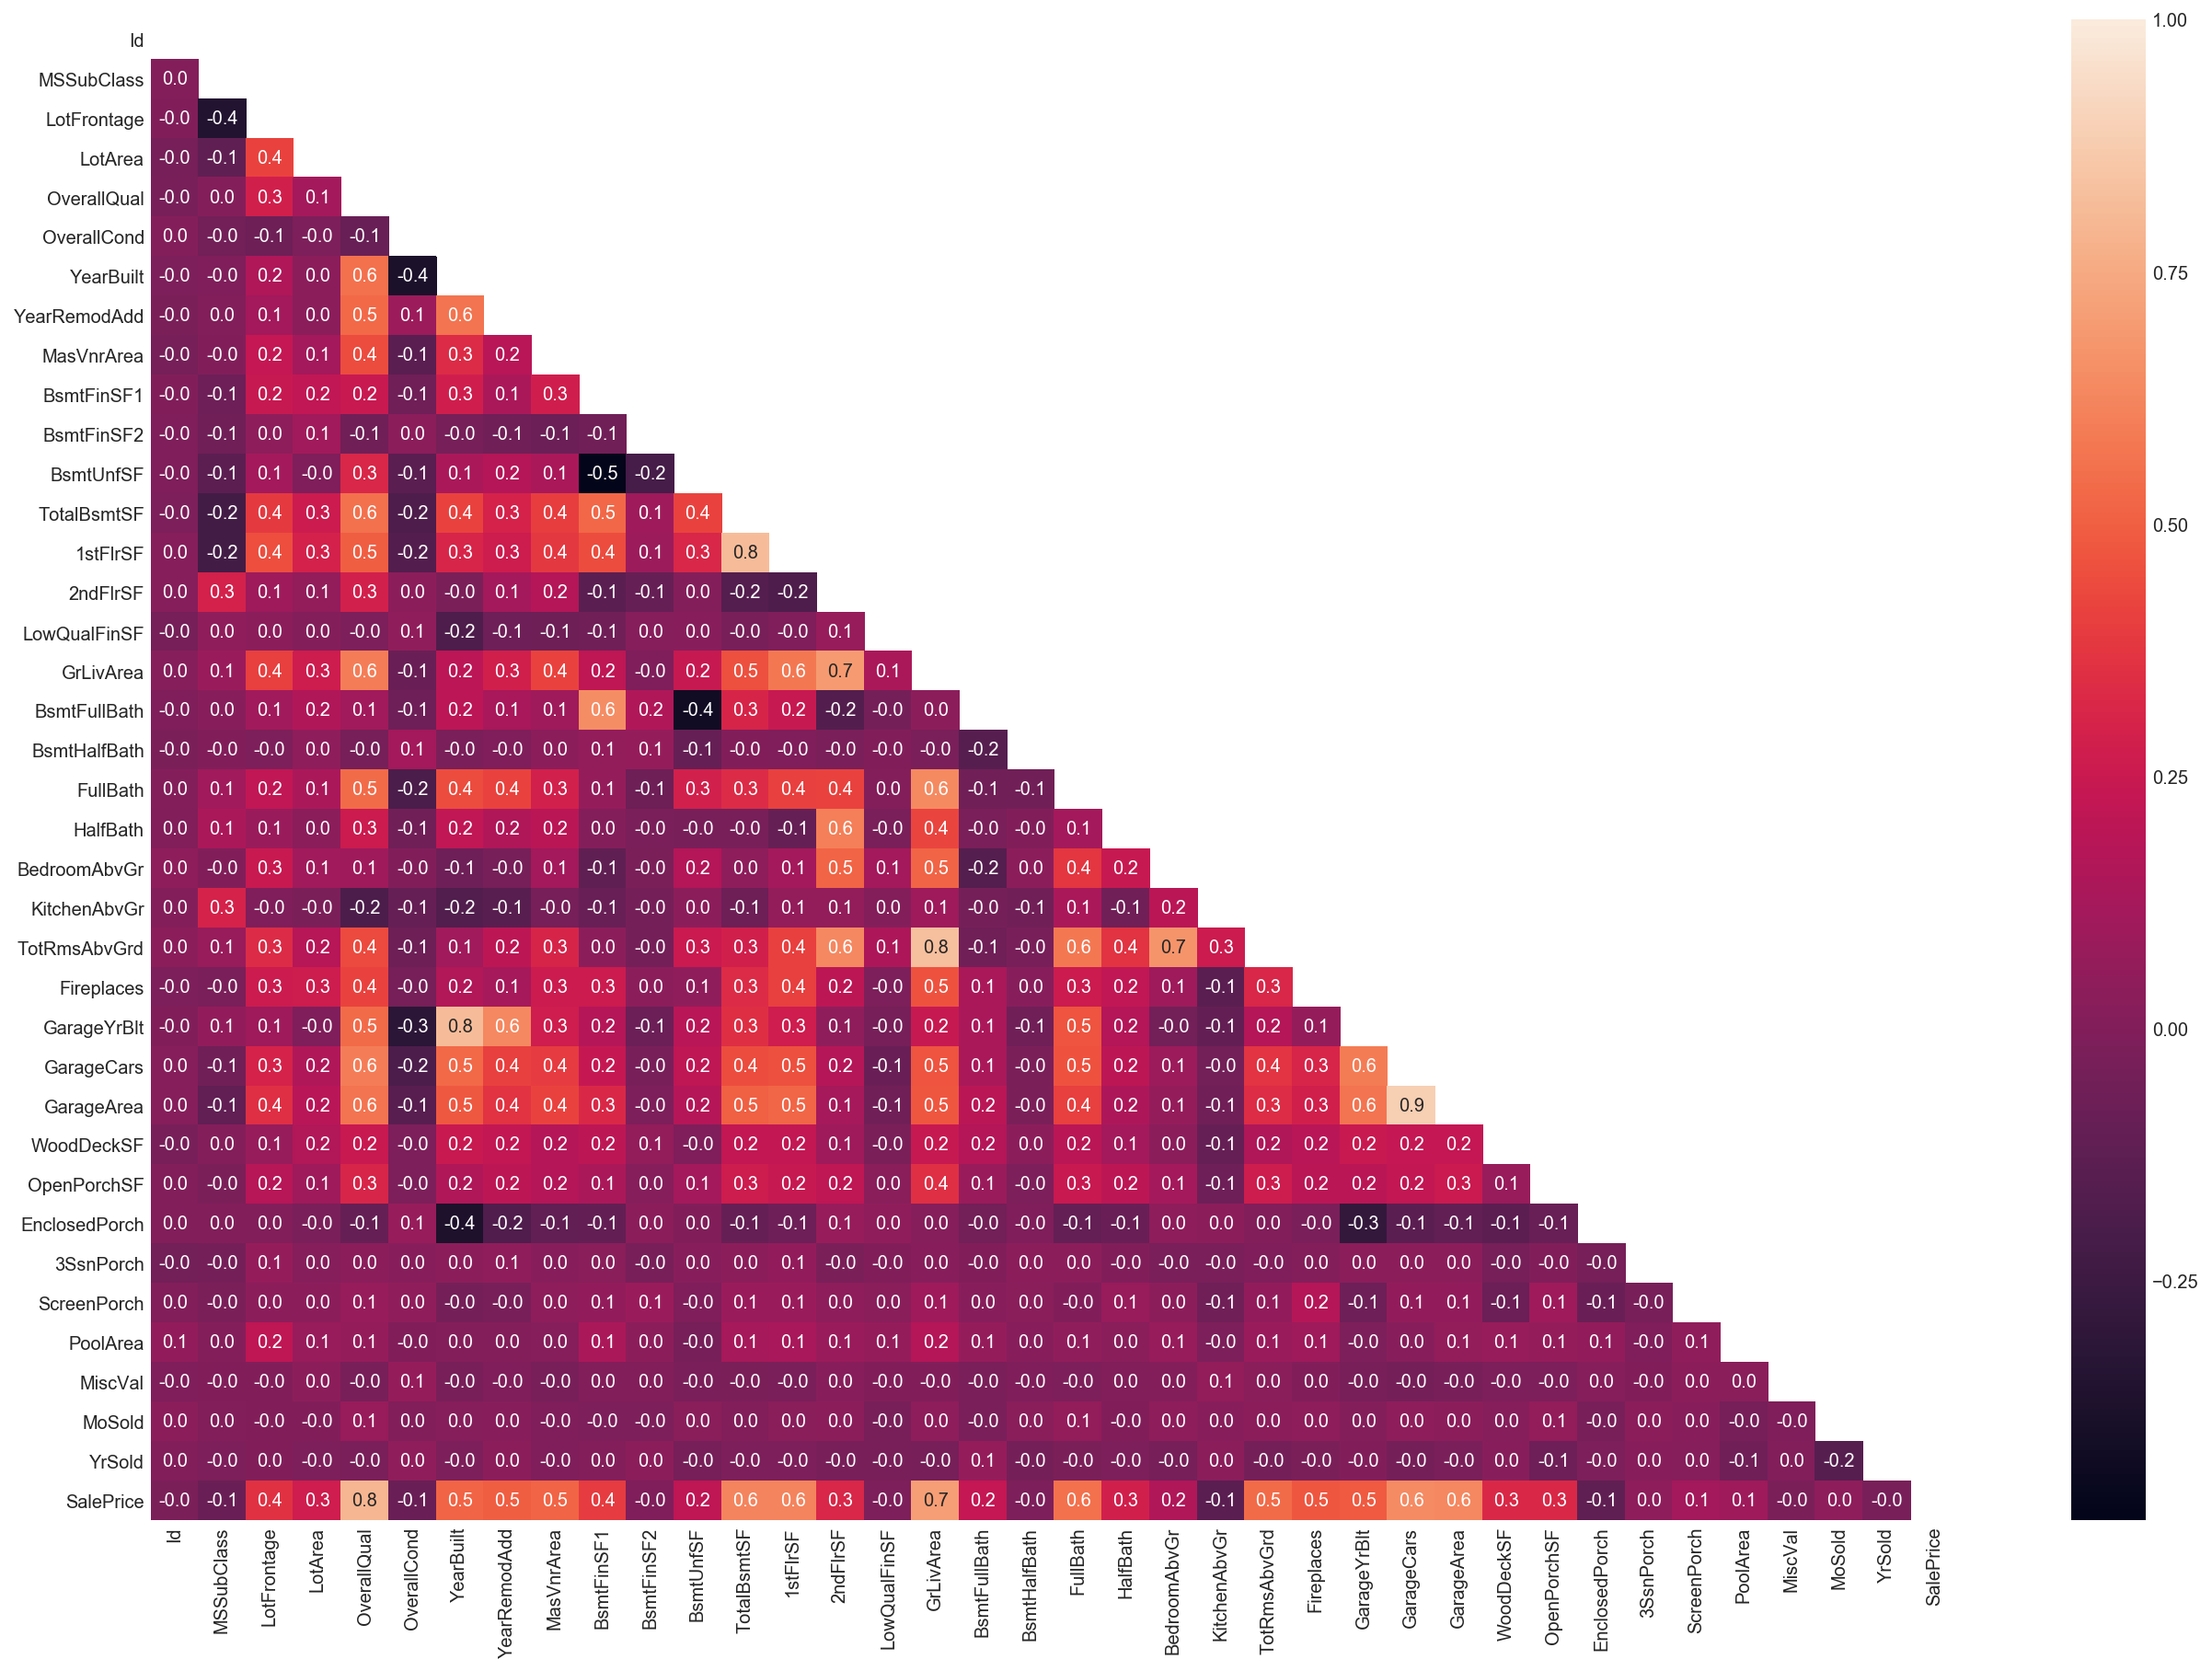

In [17]:
# A:
#house.isnull().sum()
corr=house.corr()
fig, ax = plt.subplots(figsize=(22,15))
mask=np.zeros_like(corr,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True
ax = sns.heatmap(corr,ax = ax, mask=mask,annot=True,fmt=".1f",annot_kws={'size':10})

In [18]:
# From above heatmap we can decide 'OverallQual,TotalBsmtSF and GrLivArea' have got strong potive corelation with saleprice 
#of the house.
# 'YearBuilt,YearRemodAdd,MasVnrArea,FullBath,Fireplaces'  also having potive corelation with Sales Price.
# 

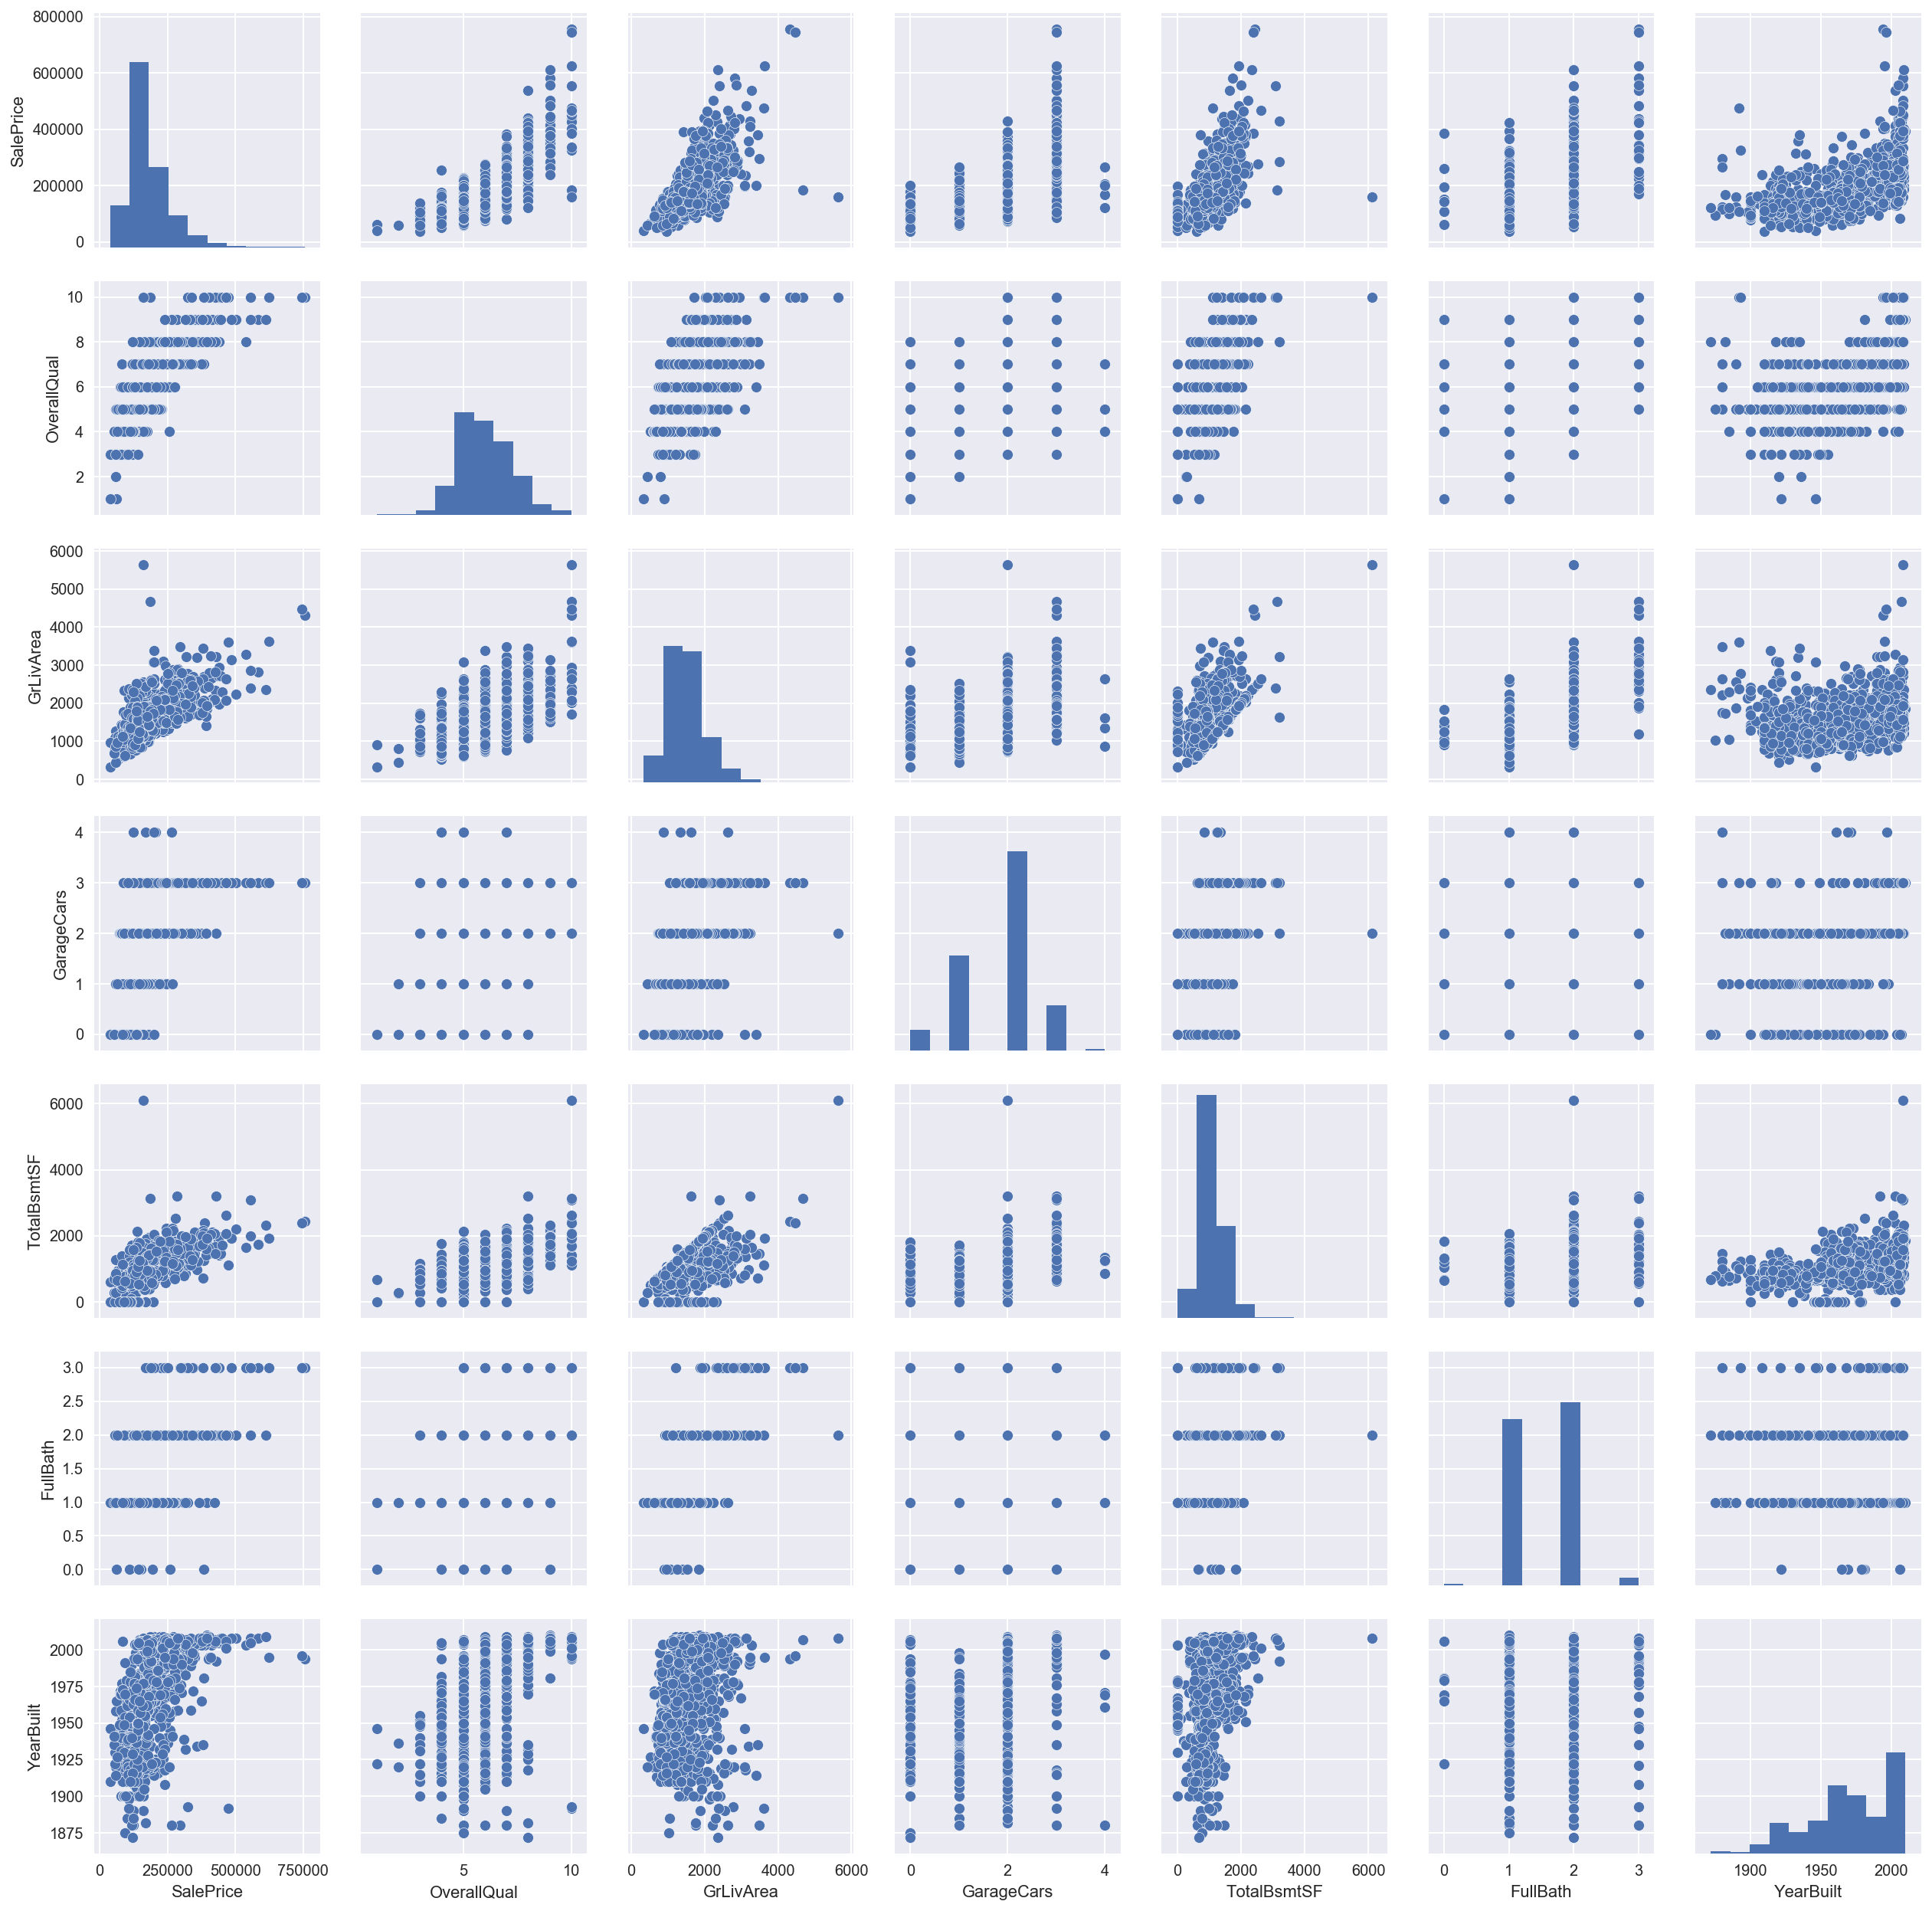

In [19]:
#sns.set()
#cols=['OverallQual','TotalBsmtSF','GrLivArea','YearBuilt','YearBuilt','YearRemodAdd','MasVnrArea','FullBath',
     # 'Fireplaces']
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(house[cols], size = 2.5)
plt.show();

In [20]:
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [21]:
# Drop columns 

#house.drop(['LotFrontage','Alley','LotShape', 'LandContour','Utilities', 'LotConfig','LandSlope','PoolQC','MiscFeature', 
           # 'MiscVal','MoSold','GarageFinish','GarageCars','GarageCond', 'PavedDrive','EnclosedPorch', '3SsnPorch',
           # 'MiscFeature','SaleType','SaleCondition'], axis=1, inplace=True)
#house.drop(['BsmtExposure','BsmtFinType1', 'BsmtFinSF1','BsmtFinType2', 'BsmtFinSF2','BsmtUnfSF','Electrical',
           # '2ndFlrSF'], axis=1, inplace=True)
#house.drop(['Condition2','MasVnrType','MasVnrArea'], axis=1, inplace=True)
#house.drop(['Exterior2nd'], axis=1, inplace=True)
house.drop(['Id'], axis=1, inplace=True)

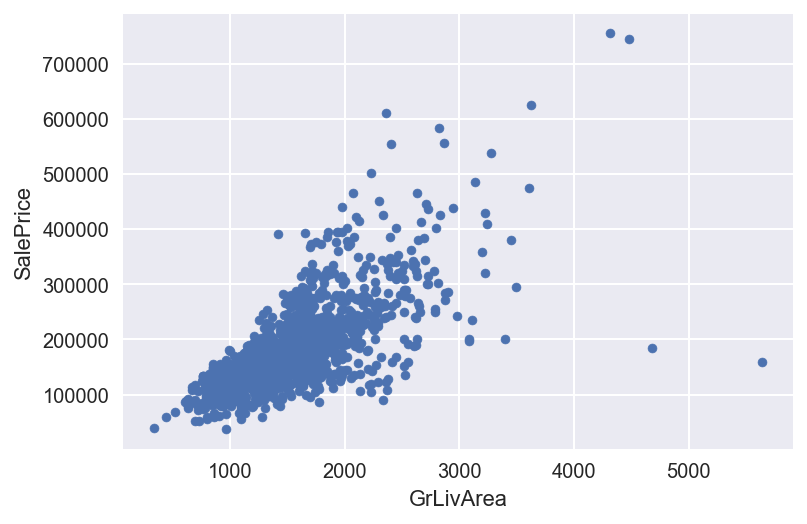

In [22]:
#outliers 
x1 = 'GrLivArea'
data = pd.concat([house['SalePrice'], house[x1]], axis=1)
data.plot.scatter(x=x1, y='SalePrice');

In [23]:
# change the MSSubClass type to string
house['MSSubClass'] = house['MSSubClass'].apply(str)

In [24]:
import sklearn.model_selection as sk
array = house.values
X = array[:,0:4]
Y = array[:,4]
t_size = 0.20
seed = 5
X_train, X_test, Y_train, Y_test = sk.train_test_split(X, Y, test_size=t_size, random_state=seed)



In [25]:
from sklearn.linear_model import Lasso
#lassoreg = Lasso(alpha=0.001, normalize=True)
#lassoreg.fit(X_train, Y_train)
#print (lassoreg.coef_)



In [26]:
house.shape

(1385, 80)

In [27]:
house.dtypes

MSSubClass        object
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
                  ...   
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object
GarageYrBlt      float64


In [30]:
# Checking for the summary statistics to understand about the features
house.describe()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1134.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1380.000000,1385.000000,1385.000000,1385.000000,...,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000
mean,70.583774,10706.158845,6.063538,5.607942,1970.048375,1984.121300,102.768841,450.666426,49.070036,562.882310,...,96.589170,43.865704,22.547292,3.594224,15.662094,2.908303,45.400722,6.314079,2007.810830,180136.283032
std,24.251032,10185.732173,1.373366,1.125799,29.831024,20.554236,174.373232,459.231291,165.258530,443.129021,...,126.994291,63.585425,62.067644,30.090182,56.883779,41.246294,509.097441,2.695583,1.326813,79906.363281
min,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,37900.000000
25%,60.000000,7711.000000,5.000000,5.000000,1953.000000,1966.000000,0.000000,0.000000,0.000000,216.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129000.000000
50%,70.000000,9591.000000,6.000000,5.000000,1971.000000,1992.000000,0.000000,387.000000,0.000000,470.000000,...,0.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000
75%,80.000000,11751.000000,7.000000,6.000000,1999.000000,2003.000000,168.000000,719.000000,0.000000,803.000000,...,169.000000,64.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,212900.000000
max,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1378.000000,5644.000000,1474.000000,2336.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [31]:
# Checking for residential houses
house['MSZoning'].sort_values().value_counts()

RL    1151
RM     218
RH      16
Name: MSZoning, dtype: int64

In [33]:
# Removing any houses that are not residential from the dataset
house = house[house.MSZoning.str.startswith(('R','F'))]

In [34]:
# Checking for unique elements in each of the object columns
# ref https://www.kaggle.com/plasticgrammer/house-prices-training
n = house.select_dtypes(include=object)
for c in n.columns:
    print(c, ': ', house[c].unique())

MSSubClass :  ['60' '20' '70' '50' '190' '45' '90' '120' '30' '85' '80' '75' '180' '160'
 '40']
MSZoning :  ['RL' 'RM' 'RH']
Street :  ['Pave' 'Grvl']
Alley :  [nan 'Grvl' 'Pave']
LotShape :  ['Reg' 'IR1' 'IR2' 'IR3']
LandContour :  ['Lvl' 'Bnk' 'Low' 'HLS']
Utilities :  ['AllPub' 'NoSeWa']
LotConfig :  ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
LandSlope :  ['Gtl' 'Mod' 'Sev']
Neighborhood :  ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Condition1 :  ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Condition2 :  ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
BldgType :  ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
HouseStyle :  ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
RoofStyle :  ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'She

In [35]:
# Checking for unique elements in each of the numeric columns
n = house.select_dtypes(exclude=object)
for c in n.columns:
    print(c, ': ', house[c].unique())

LotFrontage :  [  65.   80.   68.   60.   84.   85.   75.   nan   51.   50.   70.   91.
   72.   66.  101.   57.   44.  110.   98.   47.  108.  112.   74.  115.
   61.   48.   33.   52.  100.   89.   63.   76.   81.   95.   69.   21.
   32.   78.  121.  122.   73.   77.   64.   94.  105.   90.   55.   88.
   82.   71.   24.  120.  107.   92.  134.   40.   62.   86.  141.   97.
   54.   41.   79.  174.   99.   67.   83.   43.  103.   93.   30.  129.
  140.   34.   37.  118.   87.  116.  150.  111.   49.   96.   59.   36.
   56.   58.   38.  109.  130.   53.  137.   35.   45.  106.  104.   42.
   39.  144.  114.  102.  128.  149.  313.  168.  182.  138.  160.  152.
  124.  153.   46.]
LotArea :  [ 8450  9600 11250 ..., 17217 13175  9717]
OverallQual :  [ 7  6  8  5  9  4 10  3  1  2]
OverallCond :  [5 8 6 7 4 3 9 2 1]
YearBuilt :  [2003 1976 2001 1915 2000 1993 2004 1973 1931 1939 1965 2005 1962 2006 1960
 1929 1970 1967 1958 1930 2002 1968 2007 1951 1957 1927 1966 1959 1994 1954
 1953 1

In [36]:
# I think at this point dropping some of the columns which have more number of nulls is not a good idea.Instead,we are then 
# inspecting those features with nulls.


PoolQC : data description says NA means "No Pool". That make sense, given the huge ratio of missing value and majority of houses have no Pool at all in general

In [39]:
house['PoolQC'] = house['PoolQC'].fillna('None')
house['MiscFeature'] = house['MiscFeature'].fillna('None')
house['Alley'] = house['Alley'].fillna('None')
house['Fence'] = house['Fence'].fillna('None')
house['FireplaceQu'] = house['FireplaceQu'].fillna('None')

In [38]:
house['LotFrontage'] = house.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [37]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    house[col] = house[col].fillna('None')

In [40]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    house[col] = house[col].fillna(0)

In [41]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    house[col] = house[col].fillna(0)

In [42]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    house[col] = house[col].fillna('None')

In [43]:
house['MasVnrType'] = house['MasVnrType'].fillna('None')
house['MasVnrArea'] = house['MasVnrArea'].fillna(0)

In [44]:
house['Electrical'] = house['Electrical'].fillna(house['Electrical'].mode()[0])

In [45]:
house.isnull().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
                ..
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
FireplaceQu      0
GarageType       0
GarageYrBlt      0
GarageFinish     0
GarageCars       0
GarageArea       0
GarageQual       0
GarageCond       0
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
PoolQC      

In [46]:
fixed_features = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
                 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
                 'Alley', 'MiscFeature',
                 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType','HouseStyle',
                 'YearBuilt',
                 'MasVnrType','MasVnrArea',
                 'Foundation',
                 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1','BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
                 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF','GrLivArea',
                 'BsmtFullBath', 'BsmtHalfBath', 'FullBath','HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
                 'TotRmsAbvGrd', 'Functional',
                 'GarageType','GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
                 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF','EnclosedPorch', '3SsnPorch', 'ScreenPorch',
                 'MiscVal', 'PoolArea',  
                 'MoSold', 'YrSold', 'SaleType','SaleCondition', 'SalePrice']

In [47]:
df = house[fixed_features]

In [48]:
df.shape

(1385, 57)

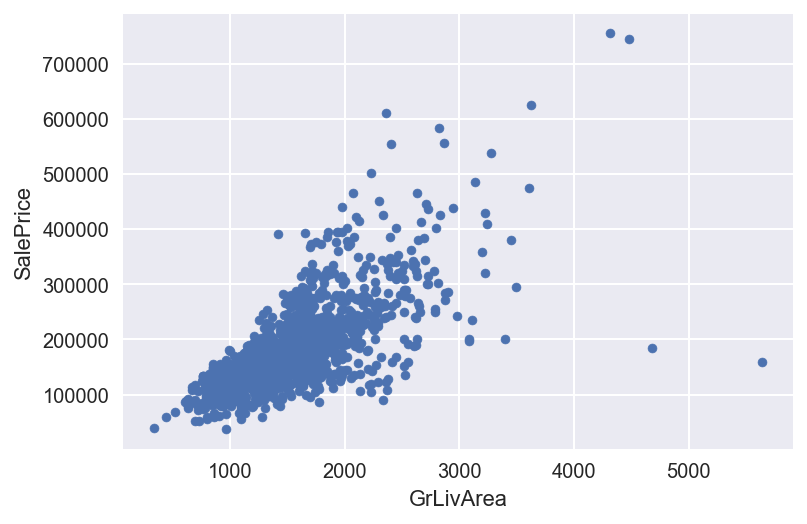

In [49]:
# Plotting SalesPrice and GrLivArea for observing any linear relationship between them
df.plot.scatter(x = 'GrLivArea', y = 'SalePrice')

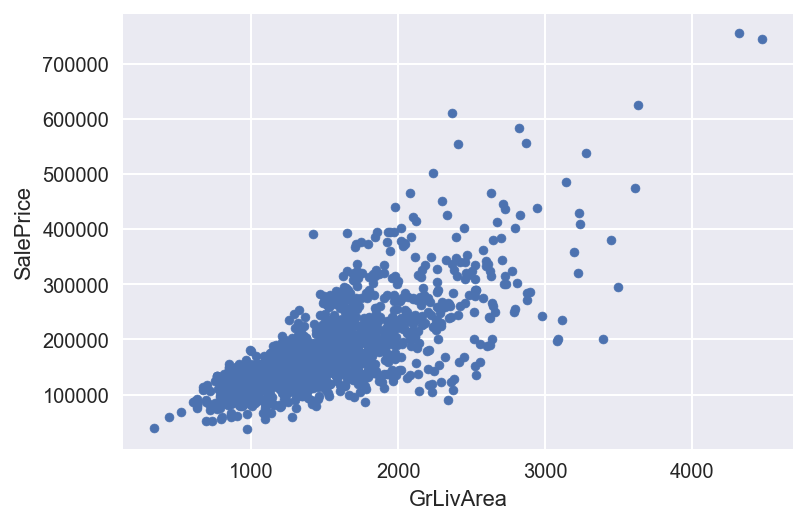

In [50]:
df = df.drop(df[(df['GrLivArea']>4000) & (df['SalePrice']<250000)].index)

#Once again plotting the graph and checking for the outliers
df.plot.scatter(x = 'GrLivArea', y = 'SalePrice')

In [51]:
df['SalePrice'].describe()

count      1383.000000
mean     180147.506869
std       79962.230090
min       37900.000000
25%      129000.000000
50%      160000.000000
75%      212950.000000
max      755000.000000
Name: SalePrice, dtype: float64

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


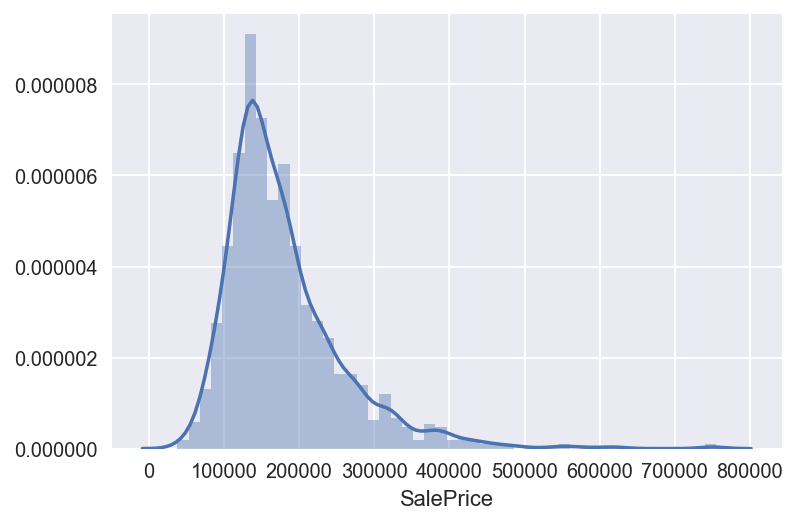

In [52]:
sns.distplot(df['SalePrice'], hist=True)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


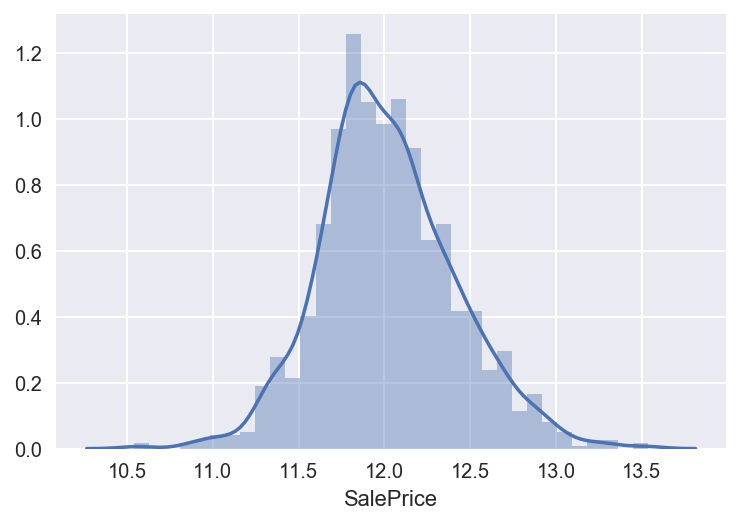

In [53]:
# We can do a log transformation on our data with the help of numpy log functionality as shown below as: log_data = np.log(data)
df['SalePrice'] = np.log(df['SalePrice'])
y = df.SalePrice

# Checking the new distribution 
sns.distplot(df['SalePrice'] , hist=True)

In [54]:
# calculate the baseline accuracy:
(y.value_counts()/y.sum()).describe()

count    626.000000
mean       0.000133
std        0.000139
min        0.000060
25%        0.000060
50%        0.000060
75%        0.000180
max        0.001203
Name: SalePrice, dtype: float64

In [56]:
print("The most important features relative to target")
corr = df.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)
#this you can see at the time of heatmap also.

The most important features relative to target
SalePrice        1.000000
GrLivArea        0.731177
GarageCars       0.686578
GarageArea       0.667088
TotalBsmtSF      0.660099
1stFlrSF         0.640484
FullBath         0.589927
YearBuilt        0.579168
TotRmsAbvGrd     0.546268
MasVnrArea       0.464866
BsmtFinSF1       0.405972
LotFrontage      0.385018
OpenPorchSF      0.345369
GarageYrBlt      0.345336
WoodDeckSF       0.339982
2ndFlrSF         0.319376
HalfBath         0.310769
LotArea          0.274264
BsmtFullBath     0.243406
BsmtUnfSF        0.222623
BedroomAbvGr     0.204787
ScreenPorch      0.127867
PoolArea         0.077864
MoSold           0.064604
3SsnPorch        0.058240
BsmtFinSF2       0.008007
BsmtHalfBath    -0.001270
MiscVal         -0.018248
YrSold          -0.039072
EnclosedPorch   -0.130010
KitchenAbvGr    -0.150481
Name: SalePrice, dtype: float64


In [57]:
# Categorical features
categorical_features = df.select_dtypes(include=['object']).columns
categorical_features

Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'Alley', 'MiscFeature', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'MasVnrType', 'Foundation', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Functional', 'GarageType', 'GarageFinish',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [58]:
# Numerical features
numerical_features = df.select_dtypes(exclude = ["object"]).columns
numerical_features

Index(['LotFrontage', 'LotArea', 'YearBuilt', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal', 'PoolArea',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [59]:
# Differentiate numerical features (dropping the target) and categorical features
categorical_features = df.select_dtypes(include = ["object"]).columns
numerical_features = df.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("SalePrice")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
df_num = df[numerical_features]
df_cat = df[categorical_features]

Numerical features : 30
Categorical features : 26


In [61]:
# Now,we simply used median() to fill na values in numerical features
print("NAs for numerical features in the dataframe : " + str(df_num.isnull().values.sum()))
df_num = df_num.fillna(df_num.median())
print("Remaining NAs for numerical features in the dataframe : " + str(df_num.isnull().values.sum()))

NAs for numerical features in the dataframe : 0
Remaining NAs for numerical features in the dataframe : 0


In [62]:
df_cat.shape

(1383, 26)

In [63]:
# Create dummy features for categorical values
df_cat = pd.get_dummies(df_cat)
df_cat.shape

(1383, 166)

In [65]:
#df_cat.head()

In [66]:
str(df_cat.isnull().values.sum())

'0'

In [67]:
df_num.isnull().sum()

LotFrontage      0
LotArea          0
YearBuilt        0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
GarageYrBlt      0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
MiscVal          0
PoolArea         0
MoSold           0
YrSold           0
dtype: int64

In [68]:
# Earlier we split the dataset into categorical and numerical features.Now after preprocessing we'll join them to get the whole 
# dataset back.
df_new = pd.concat([df_cat,df_num],axis=1)
df_new.shape

(1383, 196)

In [69]:
df_new.columns

Index(['MSSubClass_120', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190',
       'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45',
       'MSSubClass_50', 'MSSubClass_60',
       ...
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'MiscVal', 'PoolArea', 'MoSold', 'YrSold'],
      dtype='object', length=196)

Now we are going to use regularized linear regression models from the scikit learn module. I'm going to try both L1(Lasso) and L2(Ridge) regularization. I'll also define a function that returns the cross-validation rms error so we can evaluate our models and pick the best tuning par
Regularization is a very useful method to handle collinearity, filter out noise from data, and eventually prevent overfitting. The concept behind regularization is to introduce additional information (bias) to penalize extreme parameter weights.

In [70]:
X_train = df_new
y_train = df['SalePrice']

In [71]:
X_train = df_new
y_train = df['SalePrice']

In [72]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xs = ss.fit_transform(X_train)

In [73]:
Xs.shape

(1383, 196)

# Resubmission Part

In [74]:
from sklearn.cross_validation import train_test_split
df_new.YrSold.unique()

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


array([2008, 2007, 2006, 2009, 2010])

In [75]:
X_train = Xs[df_new.YrSold.isin([2006, 2007, 2008, 2009])]
X_test = Xs[df_new.YrSold == 2010]

y_train = y[df_new.YrSold.isin([2006, 2007, 2008, 2009])]
y_test = y[df_new.YrSold == 2010]

# test size can have random size

In [76]:
len(X_train)

1219

In [77]:
X_train.shape

(1219, 196)

In [78]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1219, 196), (164, 196), (1219,), (164,))

In [79]:
X_train

array([[-0.25105465, -0.17478963, -0.08534238, ..., -0.06542054,
        -1.60362215,  0.14220458],
       [-0.25105465, -0.17478963, -0.08534238, ..., -0.06542054,
        -0.48877156, -0.61131625],
       [-0.25105465, -0.17478963, -0.08534238, ..., -0.06542054,
         0.99769589,  0.14220458],
       ..., 
       [-0.25105465, -0.17478963, -0.08534238, ..., -0.06542054,
         0.25446216, -1.36483709],
       [-0.25105465, -0.17478963, -0.08534238, ..., -0.06542054,
         0.62607902, -0.61131625],
       [-0.25105465, -0.17478963, -0.08534238, ..., -0.06542054,
        -0.1171547 ,  0.14220458]])

In [80]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, make_scorer

In [81]:
from sklearn import metrics

# Linear Regression (Without Regularization)

In [82]:
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [83]:
lm.score(X_train,y_train)

0.91921718790491524

In [84]:
lm.score(X_test,y_test)

0.88686666358495081

In [85]:
y_pred = lm.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_pred, y_test))
rmse

0.13390550800022127

In [86]:
# Calculate R2 for test (2010)
from sklearn.metrics import r2_score
r2_test = r2_score(y_test, y_pred)
print(r2_test)

0.886866663585


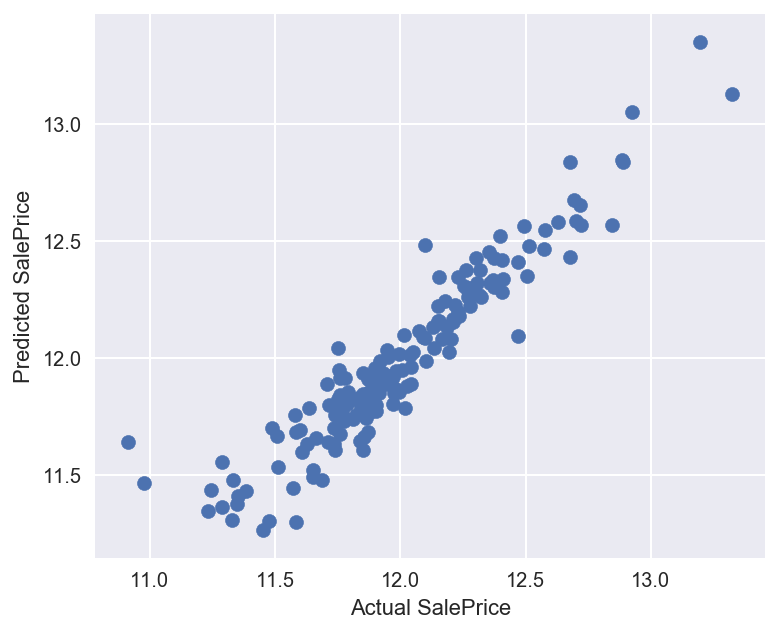

In [87]:
#Plot the predictive values vs actual values for test (2010)
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice",)
plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


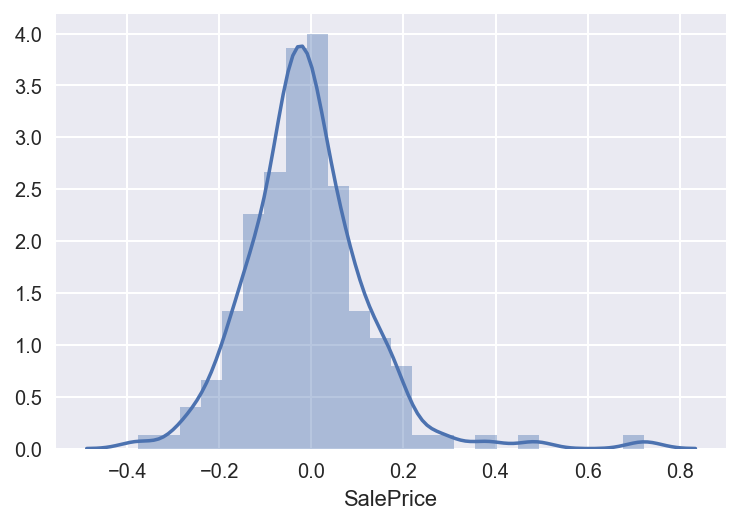

In [88]:
# Plot the distibution of residuals
residual_test = y_pred-y_test
sns.distplot(residual_test)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [97]:
house.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [98]:
house = house.drop(house[(house['GrLivArea']>4000) & (house['SalePrice']<250000)].index)

In [99]:
# According to the estimate of the price and whether the house can be renovated or not,we can divide the features into fixed and 
# dynamic
# Here,for the part 2,we are building model with dynamic features only
dynamic_features = ['OverallQual', 'OverallCond', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
                    'ExterQual', 'ExterCond','BsmtQual', 'BsmtCond','Heating', 'HeatingQC', 'CentralAir', 'Electrical', 
                    'LowQualFinSF', 'KitchenQual','Functional', 'Fireplaces', 'FireplaceQu','GarageQual','GarageCond', 'PoolQC',
                    'Fence','YrSold']

# We can put these fixed features in our dataframe
df1 = house[dynamic_features]
df1.shape

(1383, 25)

In [100]:
# Our Target variable
y = df1.YearRemodAdd

In [101]:
# calculate the baseline accuracy:
(y.value_counts()/y.sum()).describe()

count    61.000000
mean      0.000008
std       0.000009
min       0.000001
25%       0.000004
50%       0.000005
75%       0.000009
max       0.000062
Name: YearRemodAdd, dtype: float64

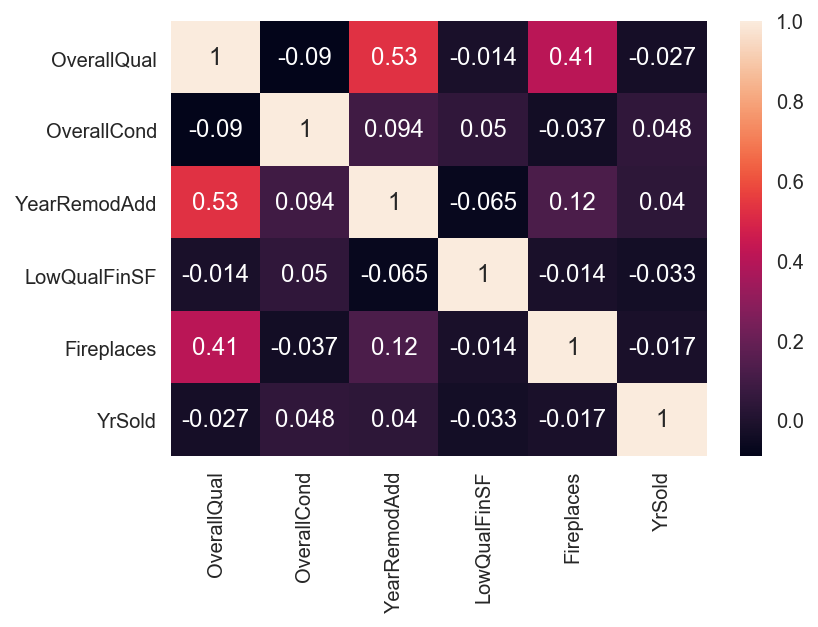

In [102]:
# Now,we have to determine any features which are highly corelated with some other features.For that,we are using heatmap
corr = df1.corr()
sns.heatmap(corr, annot=True)

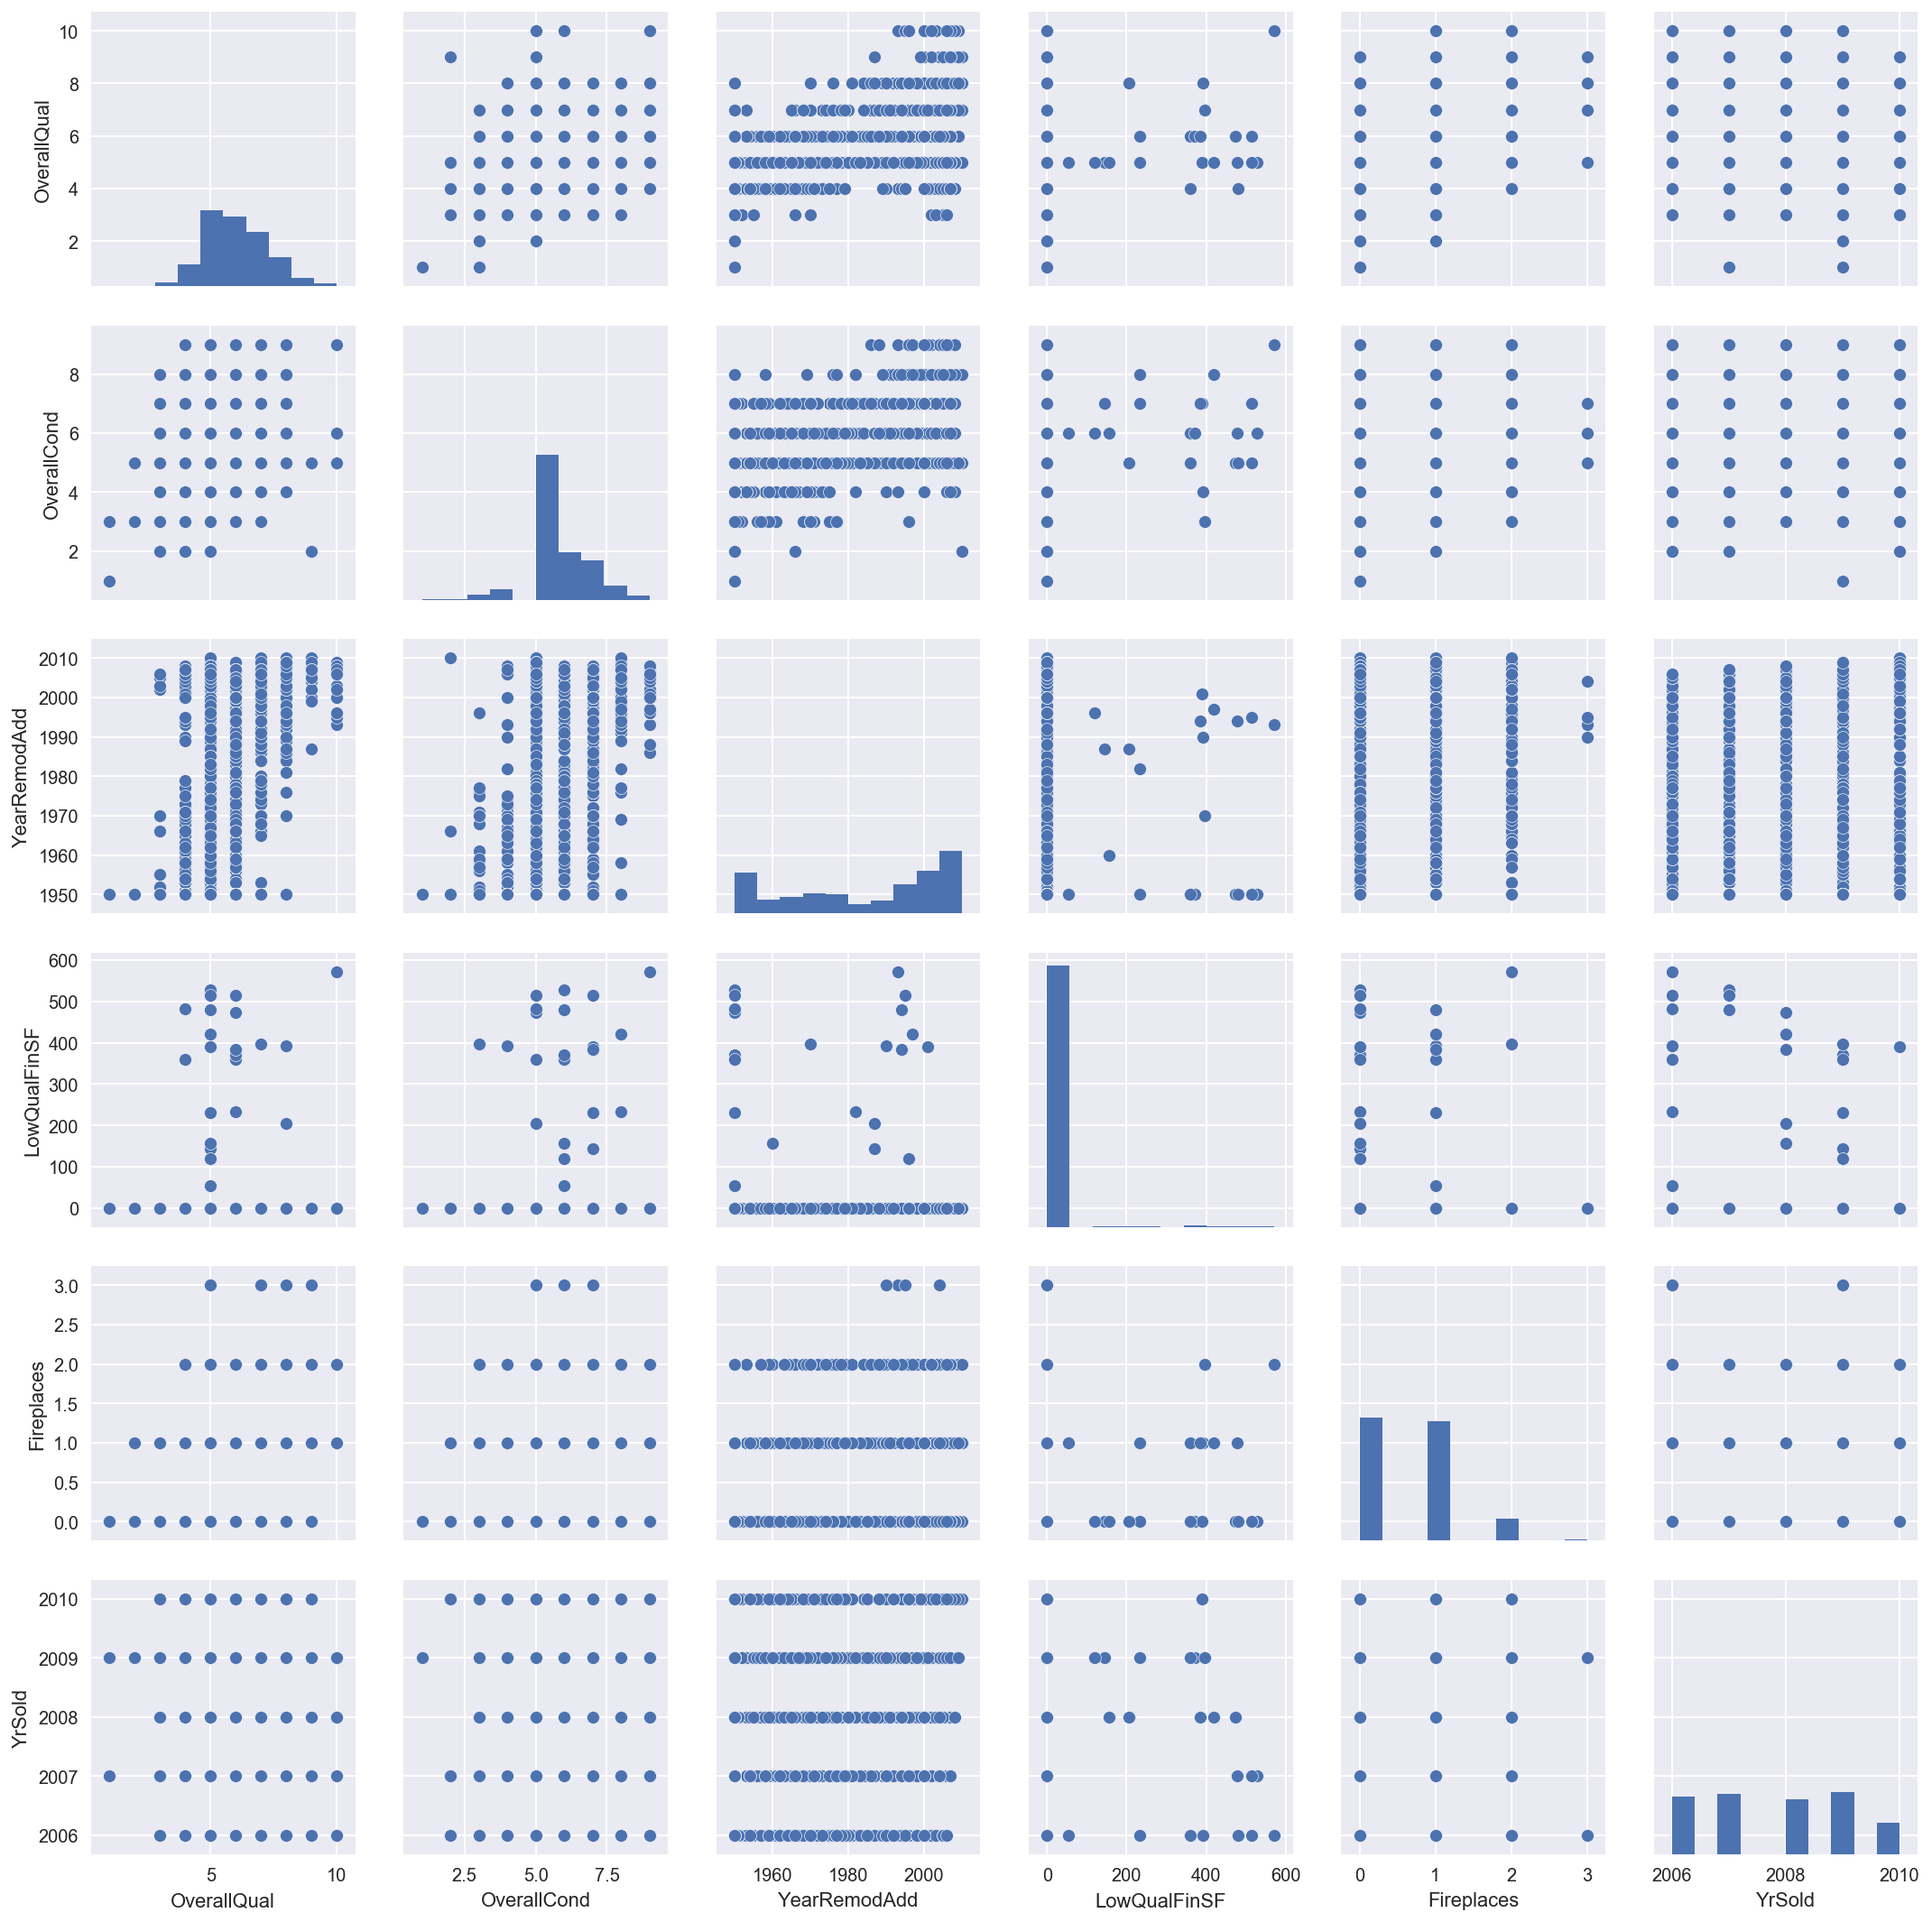

In [103]:
# Using pairplot
sns.pairplot(df1)

In [104]:
print("The most important features relative to target")
corr = df1.corr()
corr.sort_values(["YearRemodAdd"], ascending = False, inplace = True)
print(corr.YearRemodAdd)
#this you can see at the time of heatmap and pairplot also.

The most important features relative to target
YearRemodAdd    1.000000
OverallQual     0.530657
Fireplaces      0.122945
OverallCond     0.093534
YrSold          0.040360
LowQualFinSF   -0.065199
Name: YearRemodAdd, dtype: float64


In [105]:
# Categorical features
categorical_features_dy = df1.select_dtypes(include=['object']).columns
categorical_features_dy

Index(['RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual',
       'ExterCond', 'BsmtQual', 'BsmtCond', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence'],
      dtype='object')

In [106]:
# Numerical features
numerical_features_dy = df1.select_dtypes(exclude = ["object"]).columns
numerical_features_dy

Index(['OverallQual', 'OverallCond', 'YearRemodAdd', 'LowQualFinSF',
       'Fireplaces', 'YrSold'],
      dtype='object')

In [107]:
# Differentiate numerical features (dropping the target) and categorical features
categorical_features_dy = df1.select_dtypes(include = ["object"]).columns
numerical_features_dy = df1.select_dtypes(exclude = ["object"]).columns
numerical_features_dy = numerical_features_dy.drop("YearRemodAdd")
print("Numerical features_dy : " + str(len(numerical_features_dy)))
print("Categorical features_dy : " + str(len(categorical_features_dy)))
df1_numdy = df1[numerical_features_dy]
df1_catdy = df1[categorical_features_dy]

Numerical features_dy : 5
Categorical features_dy : 19


In [108]:
# Now,we simply used median() to fill na values in numerical features
print("NAs for numerical features in the dataframe : " + str(df1_numdy.isnull().values.sum()))
df1_numdy = df1_numdy.fillna(df1_numdy.median())
print("Remaining NAs for numerical features in the dataframe : " + str(df1_numdy.isnull().values.sum()))

NAs for numerical features in the dataframe : 0
Remaining NAs for numerical features in the dataframe : 0


In [109]:
df1_catdy.shape

(1383, 19)

In [110]:
# Create dummy features for categorical values
df1_catdy = pd.get_dummies(df1_catdy)
df1_catdy.shape

(1383, 119)

In [111]:
df1_catdy.head()

,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,...,GarageCond_TA,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_None,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None
0,0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,1
1,0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,1
2,0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,1
3,0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,1
4,0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,1


In [112]:
str(df1_catdy.isnull().values.sum())

'0'

In [113]:
# Earlier we split the dataset into categorical and numerical features.Now after preprocessing we'll join them to get the whole 
# dataset back.
df1_new = pd.concat([df1_catdy,df1_numdy],axis=1)
df1_new.shape

(1383, 124)

In [114]:
from sklearn.cross_validation import train_test_split
X_train = Xs[df1_new.YrSold.isin([2006, 2007, 2008, 2009])]
X_test = Xs[df1_new.YrSold == 2010]

y_train = y[df1_new.YrSold.isin([2006, 2007, 2008, 2009])]
y_test = y[df1_new.YrSold == 2010]

# test size can have random size
#X_train, X_test, y_train, y_test = train_test_split(df1, y, test_size=0.3)

In [115]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1219, 196), (164, 196), (1219,), (164,))

In [116]:
X_train

array([[-0.25105465, -0.17478963, -0.08534238, ..., -0.06542054,
        -1.60362215,  0.14220458],
       [-0.25105465, -0.17478963, -0.08534238, ..., -0.06542054,
        -0.48877156, -0.61131625],
       [-0.25105465, -0.17478963, -0.08534238, ..., -0.06542054,
         0.99769589,  0.14220458],
       ..., 
       [-0.25105465, -0.17478963, -0.08534238, ..., -0.06542054,
         0.25446216, -1.36483709],
       [-0.25105465, -0.17478963, -0.08534238, ..., -0.06542054,
         0.62607902, -0.61131625],
       [-0.25105465, -0.17478963, -0.08534238, ..., -0.06542054,
        -0.1171547 ,  0.14220458]])

In [118]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, make_scorer
ss = StandardScaler()
Xs = ss.fit_transform(X_train)

# Linear Regression (with Ridge)

In [120]:
rdgCV = RidgeCV(alphas=[0.01,0.1,1,10,100,1000], cv=5)
rdgCV.fit(X_train,y_train)

RidgeCV(alphas=[0.01, 0.1, 1, 10, 100, 1000], cv=5, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [121]:
print(rdgCV.alpha_)

1000


In [122]:
rdg = Ridge(alpha=10)
rdg.fit(X_train, y_train)
rdg.score(X_train, y_train)

0.57485500760047814

In [123]:
rdg.score(X_test, y_test)

0.25616995428939404

In [124]:
y_pred = rdg.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_pred, y_test))
rmse

17.493355237297596

In [125]:
# Calculate R2 for test (2010)
from sklearn.metrics import r2_score
r2_test = r2_score(y_test, y_pred)
print(r2_test)

0.256169954289


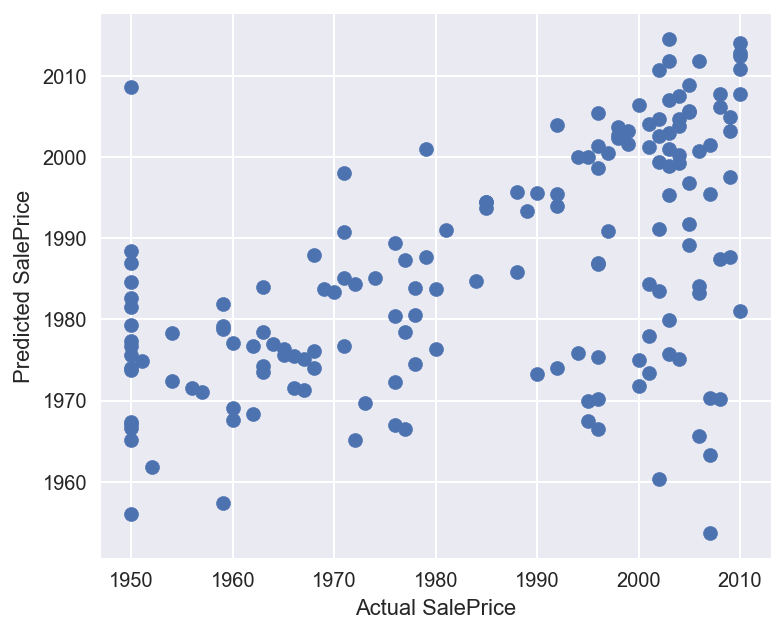

In [126]:
#Plot the predictive values vs actual values for test (2010)
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice",)
plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


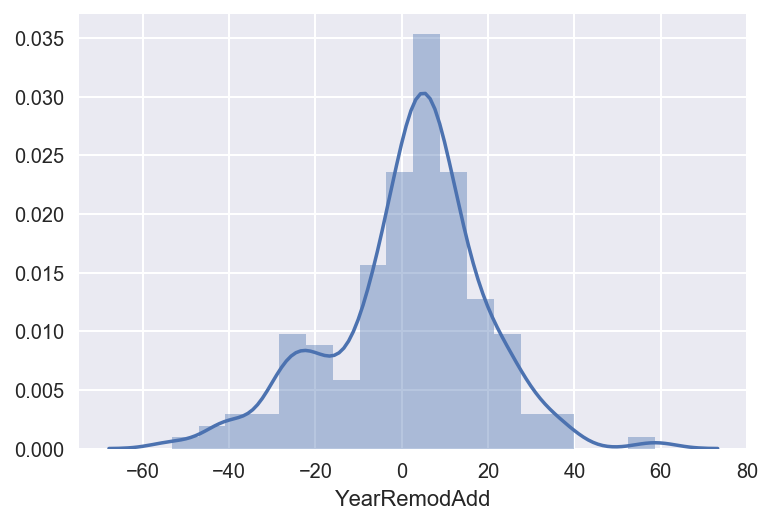

In [127]:
# Plot the distibution of residuals
residual_test = y_pred-y_test
sns.distplot(residual_test)

# Linear Regression (With Lasso)

In [129]:
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)

LassoCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1],
    copy_X=True, cv=10, eps=0.001, fit_intercept=True, max_iter=50000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [130]:
print(lasso.alpha_)

0.6


In [131]:
las = Lasso(alpha=0.0006)
las.fit(X_train, y_train)
las.score(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.58434784166384379

In [132]:
las.score(X_test, y_test)

0.21895615131375212

In [133]:
y_pred = las.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_pred, y_test))
rmse

17.925610896393529

In [134]:
# Calculate R2 for test (2010)
from sklearn.metrics import r2_score
r2_test = r2_score(y_test, y_pred)
print(r2_test)

0.218956151314


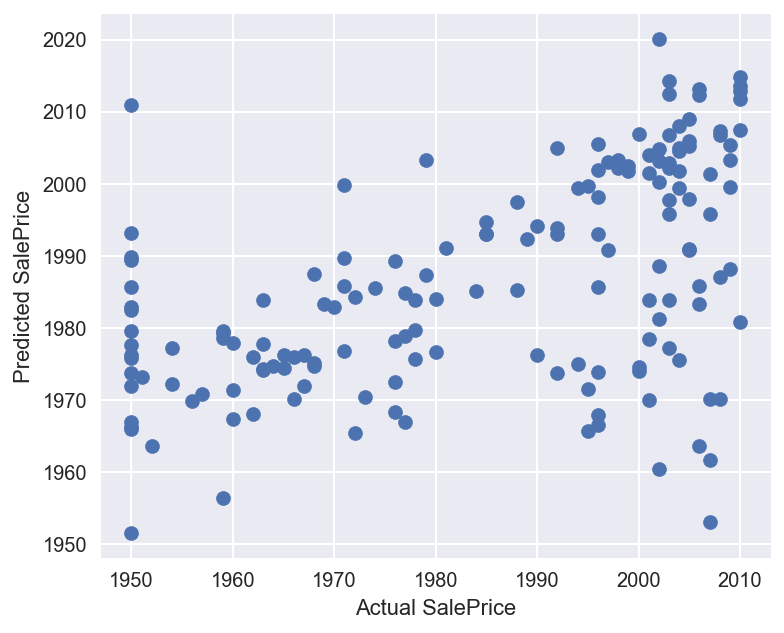

In [135]:
#Plot the predictive values vs actual values for test (2010)
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice",)
plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


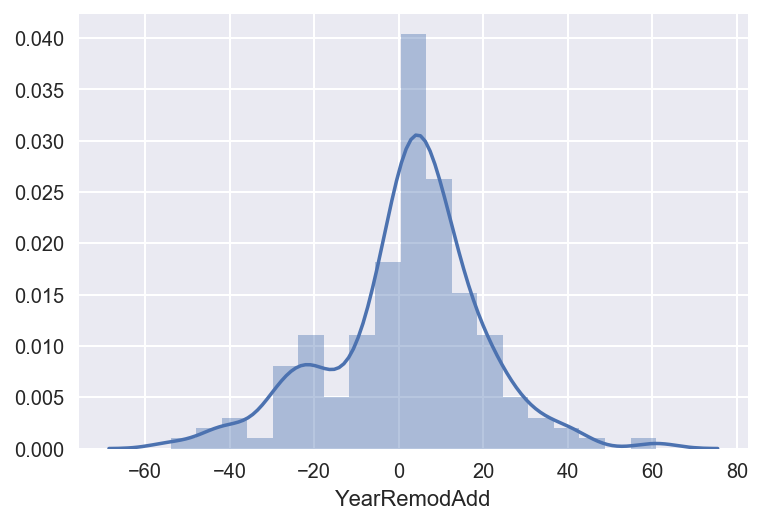

In [136]:
# Plot the distibution of residuals
residual_test = y_pred-y_test
sns.distplot(residual_test)

Comparing rigde and lasso : Ridge is performing well .Becuse Its r2 is better .(0.251)

By exploring on the model best predictors of salesprice are :GrLivArea,YearBuilt,GarageCars,Neighborhood

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [29]:
# A: